<div class="jumbotron text-left"><b>

This Notebook provides an example of how to implement an Adaptive Design of Experiments (ADOE) algorithm to train a Multi-Fidelity Kriging (MFK) model, using only the SMT toolbox.

Example for 1D input and 2 levels of fidelity, using the Forrester function.

</b></div>

Maxime LALANDE, PhD Student ONERA/DMPE/HEAT - December 2024 - `version SMT 2.6.3 and above`






# Preliminary

### MFK

Please check doc https://smt.readthedocs.io/en/stable/_src_docs/applications/mfk.html

### ADOE

For further information about the ADOE method for MFK, please refer Hugo Valayer's Master Internship Report: "*Multi-fidelity adaptive design of experiments and surrogate models for data fusion in aerodynamics*" - 2023.

### SMT
SMT is a joint library between NASA, UoM, ONERA and ISAE-SUPAERO. It offers many surrogate modeling tools with a focus on derivatives. Le Gratiet's formulation was implemented as part of SMT.

After dowmloading and installing SMT library from: https://github.com/SMTorg/smt

We import the needed packages

In [12]:
#!pip install smt
import smt
print(smt.__version__)

2.8.0


# Personnal Motivation

This script was originally developed for my thesis work. It features some variations and additions to the algorithm described by H. Valayer in his report, needed for my use:

1.   Global point selection criterion $x_{n+1}$: implementation of MMSE, VMR and MSEt with Gaussian weighting on the output. Same as H. Valayer's report.

2.   Fidelity selection criteria: we consider a cost $C_0$ for low-fidelity (LF) calculations and $C_1 > C_0$ for high-fidelity calculations. Usually, one chooses the fidelity of $x_{n+1}$ with $\underset{l \in {0,1}}{\text{argmax}} \frac{\sigma_{cont}^2 (l, \textbf{x}^*) }{C_l}$, with $\sigma_{cont}^2 (l, \textbf{x}^*)$ the contribution of fidelity level $l$ to the surrogate model variance. For my application, I can add a HF calculation to an existing LF calculation with a cost $C_1 - C_0$ (HF calculation following a LF calculation in the simulation process). This is implemented in the code (cf `get_xnew_2F_addHF`), and can be enabled with `add_HF_to_LF=True/False`.
3.   Batch size $n_{b}$ possible. Instead of selecting only a single point $x_{n+1}$, we want $\{ x_{n+1}, ..., x_{n+n_b+1} \}$ points. To ensure that all these points are not concentrated in the same region of the design space, a neighborhood is defined around each selected point, in which no additional points can be added.



In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from smt.sampling_methods import LHS
from smt.applications.mfk import MFK, NestedLHS
from smt.utils.misc import compute_rms_error
from smt.problems import LpNorm

# General settings for the Forrester 1D2F Optimization

Parameters can be modify here for some tests

In [3]:
# To save fig
save_fig = False
path_py = os.getcwd() + '/'
dir_savefig = 'fig_Forrester/'
try:
    os.mkdir(path_py + dir_savefig)
except FileExistsError:
    pass

# General settings
n_dim       = 1                         # 1D problem
n_lvl       = 2                         # Number of fidelity levels
n_doe0_HF   = 3                         # Initial DOE size (high fidelity)
xlimits     = np.array([[0.0, 1.0]])    # Input bounds
rdm_state   = 0                         # For reproductibility of LHS
n_ADOE      = 40                        # Size of ADOE
cost_ratio  = 10                        # Cost ratio HF / LF
n_eval_pts  = 201                       # Number of points for rms evaluation
add_HF_to_LF= True                      # Cost HF from scratch: cost_ratio, cost HF from LF: cost_ratio_add_HF = cost_ratio - 1, might be advantageous to add HF to a point only available with LF
batch_size  = 3                         # Number of new points to compute for each ADoE loop (batch)
n_iter_max  = 10                        # Number max iterations for ADoE
tol_rmse    = 1e-4                      # RMSE tolerance for opti
R_ball      = min(0.1,1/(2*batch_size)) # Non-dimensioned ball radius (at best 1/batch_size)

# Enrichment criteria parameters
# Available: MMSE, VMR, MSEt
name_global_criteria    = "MMSE"
y_t, eps_t_99           = 0, 5
var_t                   = (eps_t_99/3)**2
param_enrich = {"name_global_criteria":name_global_criteria, "y_t":y_t, "var_t":var_t}

# Param�tres apprentissage (noyau, polynome extrapolation)
poly = "constant"
# poly = "linear"
# poly = "quadratic"
# corr = "matern32"
# corr = "matern52"
# corr = "pow_exp"
corr = "squar_exp"
optim_corr  = False      # Optim sur corr = ['pow_exp', 'abs_exp', 'squar_exp', 'matern52', 'matern32']

# LF and HF Functions

We define here the analytical low-fidelity and high-fidelity functions.

In [4]:
def Forrester_HF(x):
    return ((6 * x - 2) ** 2) * np.sin(12 * x - 4)

def Forrester_LF(x):
    return 0.5 * ((6 * x - 2) ** 2) * np.sin(12 * x - 4) + 10 * (x - 0.5) - 5

# Enrichment criteria

#### Some utils functions



In [5]:
def var_2F(f, x):
    """Return the variance of LF and HF"""
    varAll, _   = f.predict_variances_all_levels(x)
    var_LF      = varAll[:, 0]
    var_HF      = varAll[:, 1]
    return np.array([var_LF]).T, np.array([var_HF]).T

def idInBall(x0, R, arr_x, xlimits, n_dim, order=2):
    """Ball center x0, radius R - Check if elements in arr_x are in B(x0,R)
    Return an array with the index of elements of arr_x in B(x0,R)
    -Default: Norm L2
    -Normalization w.r.t xlimits bounds => please give R=[0,1["""
    L2      = LpNorm(ndim=n_dim, order=order)
    norm    = np.array([[x[1]-x[0]] for x in xlimits])      # Normalisation factor for each dim
    x0_x    = arr_x - x0                                    # Vector x0 to x, with x in arr_x
    x0_x_n  = np.array([[ x0_x[ix][idim]/norm[idim][0]      # Normalization
                         for idim in range(n_dim) ] for ix in range(len(x0_x))])
    dist_norm = L2(x0_x_n) / n_dim**.5
    return np.where(dist_norm <= R)[0]

#### Global criteria

In [6]:
def get_id_MMSE(f, x, sup_inp=None):
    return f.predict_variances(x).argmax()

def get_id_VMR(f, x, sup_inp=None):
    return (f.predict_variances(x)/np.abs(f.predict_values(x))).argmax()

def get_id_MSEt(f, x, sup_inp):
    y_t, var_t = sup_inp[0], sup_inp[1]
    def W_Heaviside(x, y_t):
        """Heaviside weighting - 0 if x < y_t, 1 else
        Just for testing, don't use, unconsistent, compare x (1D input) and y_t (scalar output) """
        return np.heaviside(x-y_t, 0)
    def W_Gaussian(f, x, y_t, var_t):
        """Gaussian centered in y_t, with variance var_t"""
        A = (2*np.pi*(var_t + f.predict_variances(x)))**(-0.5)
        B = np.exp(-1/2 * ((f.predict_values(x) - y_t)**2)/(var_t + f.predict_variances(x)) )
        return A*B
    # W = W_Heaviside(x, y_t)  # Testing
    W = W_Gaussian(f, x, y_t, var_t)

    return (f.predict_variances(x) * W).argmax()

def glob_crit(name_global_criteria):
    if name_global_criteria == "MMSE":
        return get_id_MMSE
    if name_global_criteria == "VMR":
        return get_id_VMR
    if name_global_criteria == "MSEt":
        return get_id_MSEt

#### Fidelity selection criteria

In [7]:
def get_xnew_2F(f, x, cost_ratio, f_global_criteria, sup_inp):
    id_x                = f_global_criteria(f, x, sup_inp)

    # Variance of LF and HF on x (ADoE)
    y_var_LF, y_var_HF  = var_2F(f, x)
    var_LF              = y_var_LF[id_x]
    var_HF              = y_var_HF[id_x]

    if var_LF > var_HF/cost_ratio:      # Add LF point
        return x[id_x], 0, var_LF
    else:                               # Add HF point
        return x[id_x], 1, var_HF/cost_ratio

def get_xnew_2F_addHF(f, x, x_LF_noHF, cost_ratio, cost_ratio_add_HF, f_global_criteria, sup_inp):
    id_x           =  f_global_criteria(f, x, sup_inp)
    id_x_LF_noHF   =  f_global_criteria(f, x_LF_noHF, sup_inp)

    # Variance of LF and HF on x (ADoE)
    y_var_LF, y_var_HF  = var_2F(f, x)
    var_LF              = y_var_LF[id_x]
    var_HF              = y_var_HF[id_x]

    # Variance of HF on x_LF_noHF (points already computed with LF, but not HF yet)
    y_var_addHF         = f.predict_variances(x_LF_noHF)
    var_add_HF          = y_var_addHF[id_x_LF_noHF]

    if var_LF > var_HF/cost_ratio and var_LF>var_add_HF/cost_ratio_add_HF:                  # Add a new LF point
        return x[id_x], 0, var_LF
    elif var_HF/cost_ratio > var_LF and var_HF/cost_ratio>var_add_HF/cost_ratio_add_HF:     # Add a new HF point
        return x[id_x], 1, var_HF/cost_ratio
    else:
        return x_LF_noHF[id_x_LF_noHF], 1, var_add_HF/cost_ratio_add_HF

# Plot Mean + Variance at each iteration

In [8]:
def plot_mean_var(n_iter, x0_LF, y0_LF, x0_HF, y0_HF, x_rms, cost_ratio, x_ADOE, l_x_new, sm, fun_LF, fun_HF, path_save_fig):

    y_eval          = sm.predict_values(x_rms)
    mse             = sm.predict_variances(x_rms)
    var_LF, var_HF  = var_2F(sm, x_rms)

    # Plot Variance
    plt.figure(figsize=(7,5))
    plt.plot(x_rms, var_HF/cost_ratio, '-', label='$\sigma_{{HF}}^2 / {}$'.format(cost_ratio))
    plt.plot(x_rms, var_LF, '-', label='$\sigma_{LF}^2$')
    if n_iter > 0:
        plt.scatter(x_ADOE, var_2F(sm, x_ADOE)[1]/cost_ratio, color='k', marker="+")
        plt.scatter(x_ADOE, var_2F(sm, x_ADOE)[0],            color='k', marker="+", label="ADoE")
        for ii in range(len(l_x_new)):
            plt.scatter(l_x_new[ii][0], l_x_new[ii][2], color='r', marker="*", s=70, label="$x_{n+1}$" if ii==0 else None)
    plt.xlabel('x')
    plt.ylabel('Variance')
    plt.xlim([-0.05, 1.05])
    if n_iter > 0:
        plt.title("Iter = {} - RMSE = {:.3e}".format(n_iter, compute_rms_error(sm, x_rms, fun_HF(x_rms))))
        plt.legend(loc='upper center', borderaxespad=0.5, ncol=2, fontsize='medium') #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    elif n_iter == 0:
        plt.title("End - RMSE = {:.3e}".format(compute_rms_error(sm, x_rms, fun_HF(x_rms))))
        plt.legend(loc='upper center', borderaxespad=0.5, ncol=1, fontsize='medium') #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    plt.grid()
    plt.tight_layout()
    if save_fig:
      if n_iter > 0:
          plt.savefig("{}/Variance_Iter{}.pdf".format(path_save_fig, n_iter))
      elif n_iter == 0:
          plt.savefig("{}/Variance_Iter_end.pdf".format(path_save_fig))
    plt.show()
    plt.close()

    # Plot model and next point
    plt.figure(figsize=(7,5))
    plt.plot(x_rms, fun_HF(x_rms), '--', label='HF Function')
    plt.plot(x_rms, fun_LF(x_rms), '--', label='LF Function')
    plt.scatter(x0_HF, y0_HF, marker="o", label="HF DOE")
    plt.scatter(x0_LF, y0_LF, marker="o", label="LF DOE")
    plt.plot(x_rms, y_eval, 'g-', label='MFK Model')
    plt.fill_between(np.ravel(x_rms), np.ravel(y_eval-3*np.sqrt(mse)), np.ravel(y_eval+3*np.sqrt(mse)),
                      color='grey', alpha=0.4, label='MFK 99% CI')
    if n_iter > 0:
        plt.scatter(x_ADOE, sm.predict_values(x_ADOE), color='k', marker="+", label="ADoE")
        for ii in range(len(l_x_new)):
            if l_x_new[ii][1] == 0:
                plt.scatter(l_x_new[ii][0], fun_LF(l_x_new[ii][0]), color='r', marker="*", s=70, label="$x_{n+1}$" if ii==0 else None)
            else:
                plt.scatter(l_x_new[ii][0], fun_HF(l_x_new[ii][0]), color='r', marker="*", s=70, label="$x_{n+1}$" if ii==0 else None)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-12, 24])
    if n_iter > 0:
        plt.title("Iter = {} - RMSE = {:.3e}".format(n_iter, compute_rms_error(sm, x_rms, fun_HF(x_rms))))
        plt.legend(loc='upper left', borderaxespad=0.5, ncol=4, fontsize='medium') #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    elif n_iter == 0:
        plt.title("End - RMSE = {:.3e}".format(compute_rms_error(sm, x_rms, fun_HF(x_rms))))
        plt.legend(loc='upper left', borderaxespad=0.5, ncol=3, fontsize='medium') #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    plt.grid()
    plt.tight_layout()
    if save_fig:
      if n_iter > 0:
         plt.savefig("{}Model_Iter{}.pdf".format(path_save_fig, n_iter))
      elif n_iter == 0:
         plt.savefig("{}Model_Iter_end.pdf".format(path_save_fig))
    plt.show()
    plt.close()

# Optimization algorithm

In [9]:
def optim_1D_2F(xlimits, fun_LF, fun_HF, param_enrich, cost_ratio, add_HF_to_LF=False, n_dim=1, n_lvl=2, n_doe0_HF=3,
                n_ADOE=20, n_eval_pts=201, batch_size=1, rdm_state=0, n_iter_max=10, tol=1e-5, R_ball=0.1, optim_corr = True,
                poly = 'constant', corr = 'squar_exp'):

    # Unpacking enrichment parameters
    name_global_criteria    = param_enrich["name_global_criteria"]
    y_t                     = param_enrich["y_t"]
    var_t                   = param_enrich["var_t"]
    f_global_criteria       = glob_crit(name_global_criteria)
    if name_global_criteria == "MSEt":
        sup_inp = [y_t, var_t]
    else:
        sup_inp = None

    # Create initial DOE - Nested LHS method
    x0_LF, x0_HF    = NestedLHS(nlevel=n_lvl, xlimits=xlimits, random_state=rdm_state)(n_doe0_HF)
    y0_LF, y0_HF    = fun_LF(x0_LF), fun_HF(x0_HF)

    # Adative DOE - Predefined
    # x_ADOE_0 = LHS(xlimits=xlimits, random_state=rdm_state)(n_ADOE)  # Using LHS => missing the bounds
    x_ADOE_0 = np.linspace(xlimits[:, 0], xlimits[:, 1], n_ADOE)

    # Dataset for model evaluation of rmse
    x_rms  = np.linspace(xlimits[:, 0], xlimits[:, 1], n_eval_pts)

    # Looking for corr minimizing rms - Best corr a priori
    if optim_corr:
        m_rms, corr = np.inf, None
        for corr_i in ['pow_exp', 'abs_exp', 'squar_exp', 'matern52', 'matern32']:
            sm = MFK(theta0 = [1.0] * n_dim, poly = poly, corr = corr_i, print_global=False)
            sm.set_training_values(x0_LF, y0_LF, name=0)
            sm.set_training_values(x0_HF, y0_HF)
            sm.train()
            rms = compute_rms_error(sm, x_rms, fun_HF(x_rms))
            if rms < m_rms:
                m_rms = min(rms, m_rms)
                corr = corr_i

    # Train initial model + Model evaluation: prediction and variance
    sm = MFK(theta0 = [1.0] * n_dim, poly = poly, corr = corr, print_global=False)
    sm.set_training_values(x0_LF, y0_LF, name=0)
    sm.set_training_values(x0_HF, y0_HF)
    sm.train()

    print("\nInitial MFK Model - {}-{} - RMS Error: {:.3e}".format(poly, corr, compute_rms_error(sm, x_rms, fun_HF(x_rms))))

    x_ADOE = x_ADOE_0

    for n_iter in range(n_iter_max):

        # Determination of next batch_size points + associated fidelity (LF or HF)
        x0_LF_new   = x0_LF
        x0_HF_new   = x0_HF
        x_ADOE_new  = x_ADOE
        x0_LF_noHF  = np.delete(x0_LF_new, np.where(np.isin(x0_LF_new, x0_HF_new) == True)[0], axis=0)
        l_x_new     = []
        it_conv     = 0

        while len(l_x_new) < batch_size and it_conv < 1000:
            if add_HF_to_LF and not np.all(np.isin(x0_LF_new, x0_HF_new)): # Checking x0_LF_new != x0_HF_new
                cost_ratio_add_HF       = cost_ratio - 1
                x_new, fid_new, var_new = get_xnew_2F_addHF(sm, x_ADOE_new, x0_LF_noHF, cost_ratio, cost_ratio_add_HF, f_global_criteria, sup_inp)
            else:
                x_new, fid_new, var_new = get_xnew_2F(sm, x_ADOE_new, cost_ratio, f_global_criteria, sup_inp)

            # If add_HF_to_LF=True: x_new might already be in l_x_new in current batch (added for LF), and requested once more for HF.
            # Two possibilities: compute both LF and HF or only LF. We choose to do only LF. Next batch will decide if HF is really required.
            if np.any([x[0] == x_new for x in l_x_new]):
                pass
            else:
                l_x_new.append([x_new, fid_new, var_new])

            # Adding x_new to x0_LF_new and x0_HF_new if fid=1
            if x_new not in x0_LF_new:
                x0_LF_new   = np.concatenate((x0_LF_new, np.array([x_new])))
            if x_new not in x0_HF_new and fid_new == 1:
                x0_HF_new   = np.concatenate((x0_HF_new, np.array([x_new])))

            # Updating x_ADOE_new and x0_LF_noHF: delete point in a Ball centered around x_new.
            x_ADOE_new = np.delete(x_ADOE_new, idInBall(x_new, R_ball, x_ADOE_new, xlimits, n_dim=n_dim, order=2), axis=0)
            x0_LF_noHF = np.delete(x0_LF_noHF, idInBall(x_new, R_ball, x0_LF_noHF, xlimits, n_dim=n_dim, order=2), axis=0)

            if x_ADOE_new.size == 0:
                break
            it_conv += 1

        plot_mean_var(n_iter+1, x0_LF, y0_LF, x0_HF, y0_HF, x_rms, cost_ratio, x_ADOE, l_x_new, sm, fun_LF, fun_HF, path_py + dir_savefig)

        #  Add x_new to LF and HF
        for ii in range(len(l_x_new)):
            x_new   = l_x_new[ii][0]
            fid_new = l_x_new[ii][1]
            if x_new not in x0_LF:
                x0_LF = np.concatenate((x0_LF, np.array([x_new])))
                # print(x0_LF)
                # print(y0_LF)
                # print(fun_LF(x_new))
                y0_LF = np.concatenate((y0_LF, np.array([fun_LF(x_new)])))
            if x_new not in x0_HF and fid_new == 1:
                x0_HF = np.concatenate((x0_HF, np.array([x_new]).T))
                y0_HF = np.concatenate((y0_HF, np.array([fun_HF(x_new)])))

        # Delete x_new from ADOE
        for ii in range(len(l_x_new)):
            x_new = l_x_new[ii][0]
            x_ADOE = np.delete(x_ADOE, np.where(x_ADOE == x_new)[0], axis=0)

        # Looking for corr minimizing rms - Best corr a priori for current ADoE
        if optim_corr:
            m_rms, corr = np.inf, None
            for corr_i in ['pow_exp', 'abs_exp', 'squar_exp', 'matern52', 'matern32']:
                sm = MFK(theta0 = [1.0] * n_dim, poly = poly, corr = corr_i, print_global=False)
                sm.set_training_values(x0_LF, y0_LF, name=0)
                sm.set_training_values(x0_HF, y0_HF)
                sm.train()
                rms = compute_rms_error(sm, x_rms, fun_HF(x_rms))
                if rms < m_rms:
                    m_rms = min(rms, m_rms)
                    corr = corr_i

        # Train new model
        sm = MFK(theta0 = [1.0] * n_dim, poly = poly, corr = corr, print_global=False)
        sm.set_training_values(x0_LF, y0_LF, name=0)
        sm.set_training_values(x0_HF, y0_HF)
        sm.train()

        print("\nIter = {} - {}-{} - RMS Error: {:.3e}".format(n_iter+1, poly, corr, compute_rms_error(sm, x_rms, fun_HF(x_rms))))

        if (compute_rms_error(sm, x_rms, fun_HF(x_rms)) < tol) or (x_ADOE.size < 1):
            break


    # Final Model
    plot_mean_var(0, x0_LF, y0_LF, x0_HF, y0_HF, x_rms, cost_ratio, x_ADOE, l_x_new, sm, fun_LF, fun_HF, path_py + dir_savefig)

# Run test

D:\bartoli\Documents\Dev_Python311\Run\Notebooks_smt28/

Initial MFK Model - constant-squar_exp - RMS Error: 1.249e+00


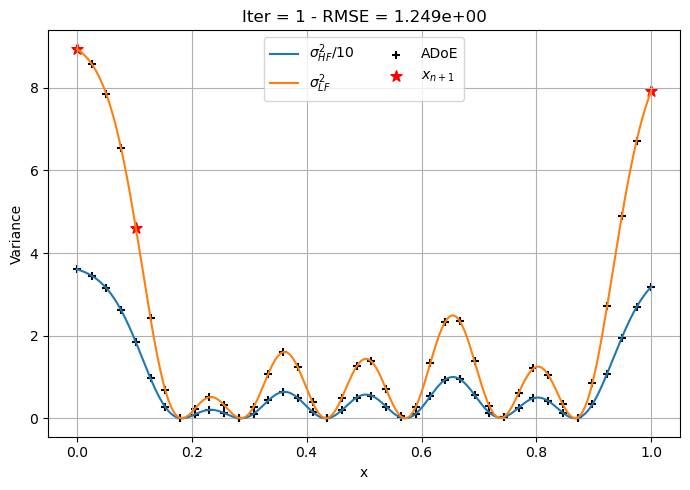

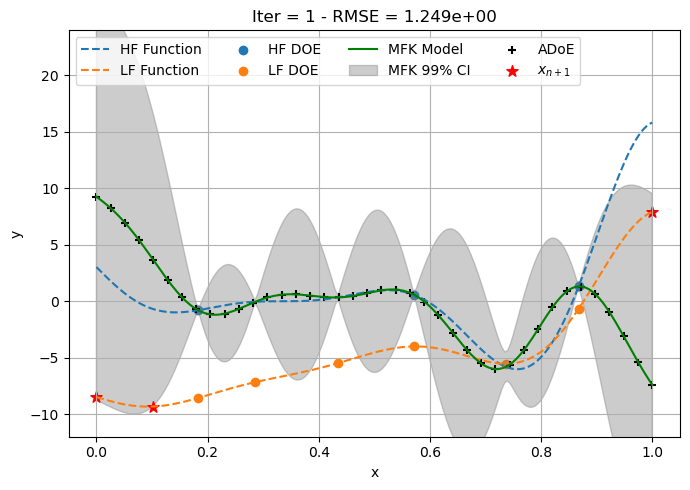


Iter = 1 - constant-squar_exp - RMS Error: 6.533e-02


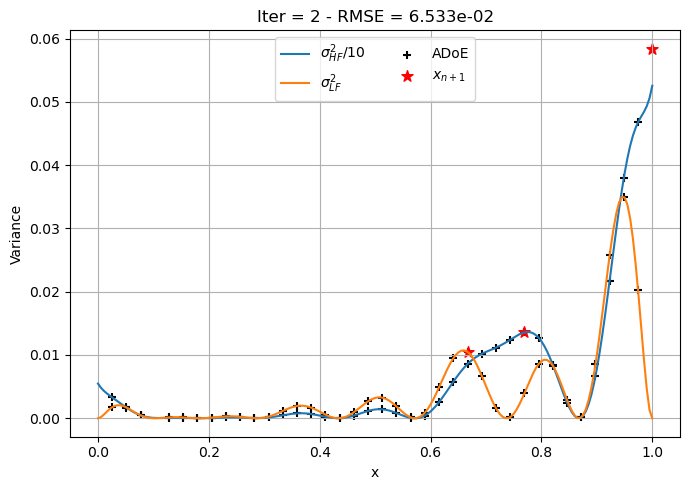

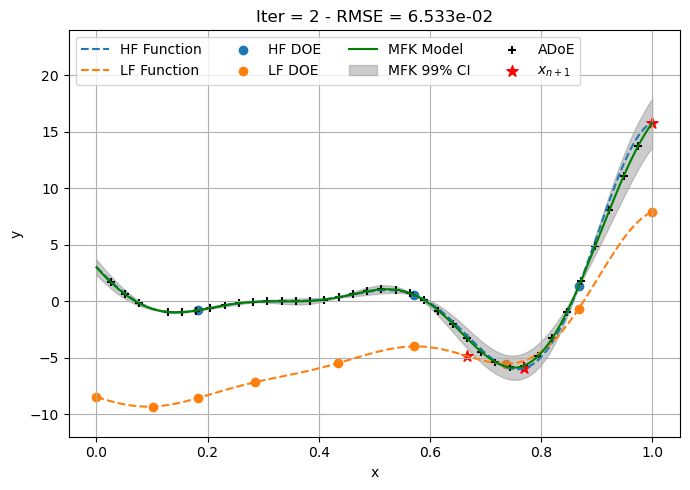


Iter = 2 - constant-squar_exp - RMS Error: 1.480e-02


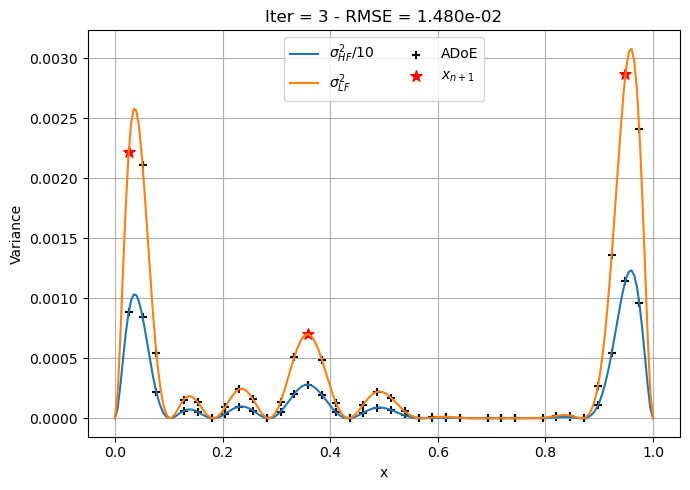

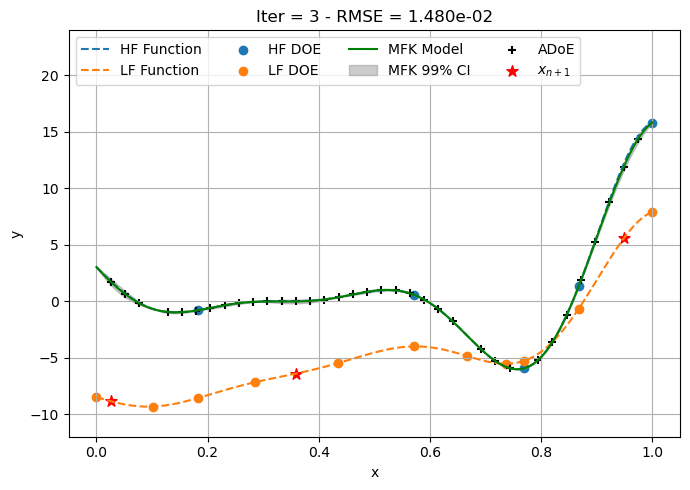


Iter = 3 - constant-squar_exp - RMS Error: 9.892e-05


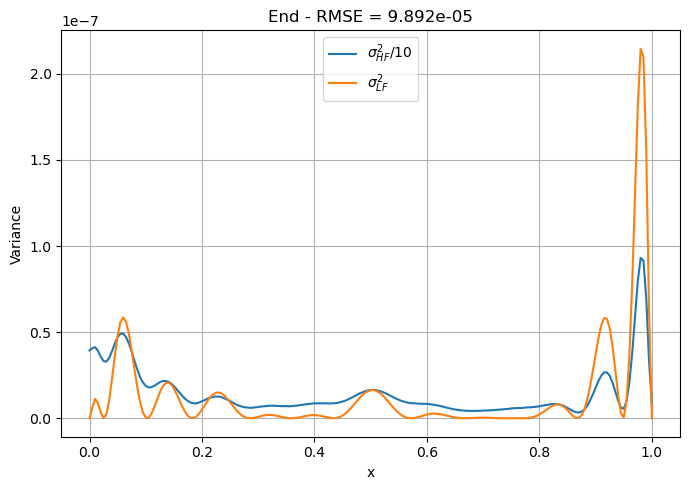

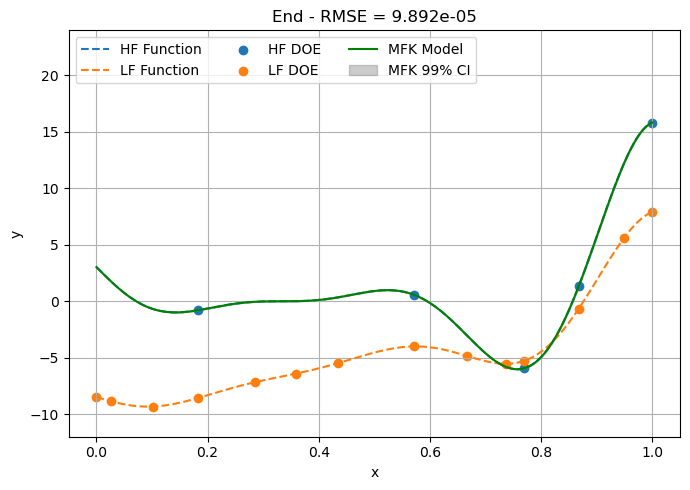

In [10]:
print(path_py)

optim_1D_2F(xlimits, Forrester_LF, Forrester_HF, param_enrich, cost_ratio, add_HF_to_LF = add_HF_to_LF,
            n_dim=n_dim, n_lvl=n_lvl, n_doe0_HF=n_doe0_HF, n_ADOE=n_ADOE, n_eval_pts=n_eval_pts,
            batch_size=batch_size, rdm_state=rdm_state, n_iter_max=n_iter_max, tol=tol_rmse,
            R_ball=R_ball, optim_corr=optim_corr, poly = poly, corr = corr)